<a href="https://colab.research.google.com/github/Torsha-Sett/Toxic-comment-challenge/blob/main/LSTM_BiLSTM_GRU.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/jigsaw-toxic-comment-classification-challenge/train.csv.zip
/kaggle/input/jigsaw-toxic-comment-classification-challenge/sample_submission.csv.zip
/kaggle/input/jigsaw-toxic-comment-classification-challenge/test_labels.csv.zip
/kaggle/input/jigsaw-toxic-comment-classification-challenge/test.csv.zip


In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt

import nltk
from nltk.stem.porter import PorterStemmer
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize

from nltk.corpus import stopwords
nltk.download('stopwords')
stop_words = stopwords.words('english')
import html
import unicodedata

import spacy
import pandas as pd
import numpy as np
from tqdm.auto import tqdm
import re
import string

import seaborn as sns
import matplotlib.pyplot as plt


from tensorflow.keras.preprocessing.text import text_to_word_sequence
from tensorflow.keras.preprocessing.text import Tokenizer  
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras import losses
from tensorflow.keras import metrics
from tensorflow.keras import optimizers
from tensorflow.keras.utils import plot_model




[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
# load data
train = pd.read_csv('../input/jigsaw-toxic-comment-classification-challenge/train.csv.zip')
test = pd.read_csv('../input/jigsaw-toxic-comment-classification-challenge/test.csv.zip')


In [ ]:
#sample text to visualize
train.sample(1)['comment_text'].values[0]


"Winamp sound very Windows to me; what't the Mac version? I'd like to hear the excerpts before we decide what is retained, and where. Compression sounds as though it could solve some problems."

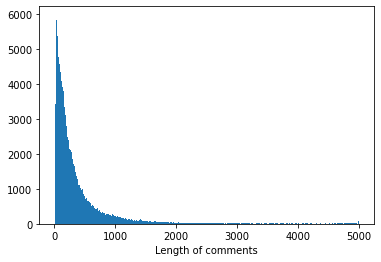

In [ ]:
sentence_lengths = [len(sentence) for sentence in train['comment_text']]
plt.hist(sentence_lengths,500)
plt.xlabel('Length of comments')
plt.show()


Text(0.5, 0, 'Feature Labels')

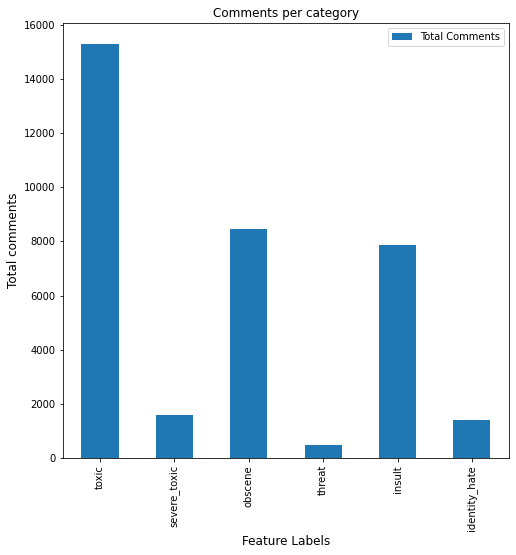

In [ ]:
feature = train.drop(['id', 'comment_text'], axis=1)     ### Removed unnecessary columns - id and comment_text
counts = []                                               ### A list that contains tuple which consists of class label and number of comments for that particular class 
categories = list(feature.columns.values)
for i in categories:
    counts.append((i, feature[i].sum()))
    
df_1 = pd.DataFrame(counts, columns=['Feature Labels', 'Total Comments'])   ### Dataframe made up of category and total number of comments
df_1.plot(x='Feature Labels', y='Total Comments', kind='bar',figsize=(8,8))
plt.title("Comments per category")
plt.ylabel('Total comments', fontsize=12)
plt.xlabel('Feature Labels', fontsize=12)

## Text preprocessing


In [ ]:
import string

def remove_special_chars(text):
    re1 = re.compile(r'  +')
    x1 = text.lower().replace('#39;', "'").replace('amp;', '&').replace('#146;', "'").replace(
        'nbsp;', ' ').replace('#36;', '$').replace('\\n', "\n").replace('quot;', "'").replace(
        '<br />', "\n").replace('\\"', '"').replace('<unk>', 'u_n').replace(' @.@ ', '.').replace(
        ' @-@ ', '-').replace('\\', ' \\ ')
    return re1.sub(' ', html.unescape(x1))


def to_lowercase(text):
    return text.lower()



def remove_punctuation(text):
    """Remove punctuation from list of tokenized words"""
    translator = str.maketrans('', '', string.punctuation)
    return text.translate(translator)


def replace_numbers(text):
    """Replace all interger occurrences in list of tokenized words with textual representation"""
    return re.sub(r'\d+', '', text)


def remove_whitespaces(text):
    return text.strip()


def remove_stopwords(words, stop_words):
    """
    :param words:
    :type words:
    :param stop_words: from sklearn.feature_extraction.stop_words import ENGLISH_STOP_WORDS
    or
    from spacy.lang.en.stop_words import STOP_WORDS
    :type stop_words:
    :return:
    :rtype:
    """
    return [word for word in words if word not in stop_words]


def stem_words(words):
    """Stem words in text"""
    stemmer = PorterStemmer()
    return [stemmer.stem(word) for word in words]

def lemmatize_words(words):
    """Lemmatize words in text"""

    lemmatizer = WordNetLemmatizer()
    return [lemmatizer.lemmatize(word) for word in words]

def lemmatize_verbs(words):
    """Lemmatize verbs in text"""

    lemmatizer = WordNetLemmatizer()
    return ' '.join([lemmatizer.lemmatize(word, pos='v') for word in words])

def text2words(text):
    return word_tokenize(text)

def clean_text( text):
    text = remove_special_chars(text)
    text = remove_punctuation(text)
    text = to_lowercase(text)
    text = replace_numbers(text)
    words = text2words(text)
    words = remove_stopwords(words, stop_words)
    #words = stem_words(words)# Either stem ovocar lemmatize
    words = lemmatize_words(words)
    words = lemmatize_verbs(words)

    return ''.join(words)

train['comment_text'] = train['comment_text'].apply(lambda x: clean_text(x))
train.sample(1)['comment_text'].values[0]


'yet remain confusion mention sac withdraw bergstrom deactivate consolidate use show consolidation unit long ago deactivate presumably consolidate deactivation time unite nothing present intro give one overall understand history'

In [ ]:
test['comment_text'] = test['comment_text'].apply(lambda x: clean_text(x))


## BoW 

In [ ]:
tok = Tokenizer(num_words=1000, oov_token='UNK')
tok.fit_on_texts(train['comment_text'] )
# Extract binary BoW features
x_train = tok.texts_to_sequences(train['comment_text'])
x_test = tok.texts_to_sequences(test['comment_text'])

vocab_size = len(tok.word_index) + 1
vocab_size

208776

## LSTM

In [ ]:
maxlen = max([len(t) for t in x_train])
maxlen


1250

In [ ]:
training_padded = pad_sequences(x_train,
                                maxlen=50, 
                                truncating='post', 
                                padding='post'
                               )
test_padded = pad_sequences(x_test,
                            maxlen=50, 
                            truncating='post', 
                            padding='post'
                               )



In [ ]:


model = models.Sequential()
model.add(layers.Embedding(vocab_size, 128, input_length=50))
model.add(layers.LSTM(512, dropout=0.2, recurrent_dropout=0.2, return_sequences=True))
model.add(layers.LSTM(128, dropout=0.2,recurrent_dropout=0.2))
model.add(layers.Dense(16, activation='relu'))
model.add(layers.Dense(6, activation='sigmoid'))



model.compile(
    loss='binary_crossentropy',
    optimizer='Adamax',
    metrics=['accuracy'])

model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 50, 128)           26723328  
_________________________________________________________________
lstm_3 (LSTM)                (None, 50, 512)           1312768   
_________________________________________________________________
lstm_4 (LSTM)                (None, 128)               328192    
_________________________________________________________________
dense_4 (Dense)              (None, 16)                2064      
_________________________________________________________________
dense_5 (Dense)              (None, 6)                 102       
Total params: 28,366,454
Trainable params: 28,366,454
Non-trainable params: 0
_________________________________________________________________


In [ ]:
history = model.fit(training_padded,
                     train[['toxic' ,'severe_toxic' ,'obscene' ,'threat' ,'insult' ,'identity_hate']],
                    epochs=5,
                    batch_size=512,
                   validation_split=0.2)

Epoch 1/5
250/250 [==============================] - 115s 445ms/step - loss: 0.3251 - accuracy: 0.0046 - val_loss: 0.1567 - val_accuracy: 0.0034
Epoch 2/5
250/250 [==============================] - 110s 439ms/step - loss: 0.1450 - accuracy: 0.6387 - val_loss: 0.1420 - val_accuracy: 0.9941
Epoch 3/5
250/250 [==============================] - 109s 436ms/step - loss: 0.1415 - accuracy: 0.9942 - val_loss: 0.1411 - val_accuracy: 0.9941
Epoch 4/5
250/250 [==============================] - 110s 439ms/step - loss: 0.1412 - accuracy: 0.9942 - val_loss: 0.1410 - val_accuracy: 0.9941
Epoch 5/5
250/250 [==============================] - 109s 437ms/step - loss: 0.1411 - accuracy: 0.9942 - val_loss: 0.1409 - val_accuracy: 0.9941


In [ ]:
history_dict = history.history
history_dict.keys()
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']


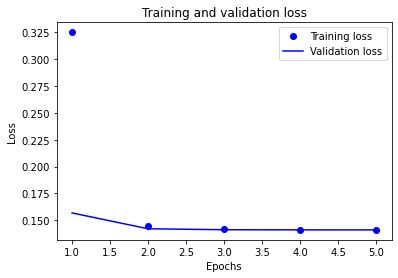

In [ ]:

epochs = range(1, len(acc) + 1)

# "bo" is for "blue dot"
plt.plot(epochs, loss, 'bo', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

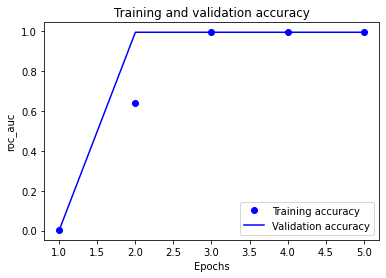

In [ ]:

plt.plot(epochs, acc, 'bo', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('roc_auc')
plt.legend()

plt.show()

## Bidirectional

In [ ]:

lstm_dim = 32
model_bilstm = models.Sequential()
model_bilstm.add(layers.Embedding(vocab_size, 512, input_length=50))
model_bilstm.add(layers.Bidirectional(layers.LSTM(128, dropout=0.2, recurrent_dropout=0.2, return_sequences=True)))
model_bilstm.add(layers.Flatten())
model_bilstm.add(layers.Dense(16, activation='relu'))
model_bilstm.add(layers.Dense(6, activation='sigmoid'))


model_bilstm.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])

# Print the model summary
model_bilstm.summary()

history = model_bilstm.fit(training_padded,
                     train[['toxic' ,'severe_toxic' ,'obscene' ,'threat' ,'insult' ,'identity_hate']],
                    epochs=5,
                    batch_size=512,
                   validation_split=0.2)

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 50, 512)           106893312 
_________________________________________________________________
bidirectional_1 (Bidirection (None, 50, 256)           656384    
_________________________________________________________________
flatten_1 (Flatten)          (None, 12800)             0         
_________________________________________________________________
dense_6 (Dense)              (None, 16)                204816    
_________________________________________________________________
dense_7 (Dense)              (None, 6)                 102       
Total params: 107,754,614
Trainable params: 107,754,614
Non-trainable params: 0
_________________________________________________________________
Epoch 1/5
250/250 [==============================] - 118s 459ms/step - loss: 0.0926 - accuracy: 0.9457 - v

In [ ]:
history_dict = history.history
history_dict.keys()
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

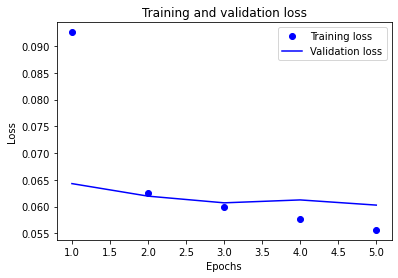

In [ ]:
epochs = range(1, len(acc) + 1)

# "bo" is for "blue dot"
plt.plot(epochs, loss, 'bo', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

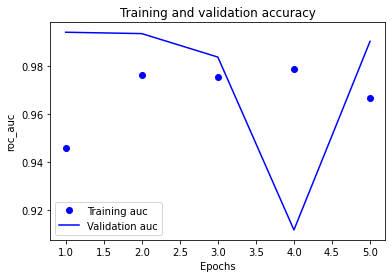

In [ ]:
plt.plot(epochs, acc, 'bo', label='Training auc')
plt.plot(epochs, val_acc, 'b', label='Validation auc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('roc_auc')
plt.legend()

plt.show()

## GRU

In [ ]:

model_gru = models.Sequential()
model_gru.add(layers.Embedding(1000, 20, input_length=maxlen))
model_gru.add(layers.Bidirectional(layers.GRU(64)))
model_gru.add(layers.Flatten())
model_gru.add(layers.Dense(6, activation='sigmoid'))

# Set the training parameters
model_gru.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])

# Print the model summary
model_gru.summary()


history = model_gru.fit(training_padded,
                     train[['toxic' ,'severe_toxic' ,'obscene' ,'threat' ,'insult' ,'identity_hate']],
                    epochs=5,
                    batch_size=128,
                   validation_split=0.2)

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, 1250, 20)          20000     
_________________________________________________________________
bidirectional_2 (Bidirection (None, 128)               33024     
_________________________________________________________________
flatten_2 (Flatten)          (None, 128)               0         
_________________________________________________________________
dense_8 (Dense)              (None, 6)                 774       
Total params: 53,798
Trainable params: 53,798
Non-trainable params: 0
_________________________________________________________________
Epoch 1/5


2022-07-15 16:05:03.147385: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


998/998 [==============================] - 13s 9ms/step - loss: 0.0911 - accuracy: 0.9555 - val_loss: 0.0652 - val_accuracy: 0.9941
Epoch 2/5
998/998 [==============================] - 8s 8ms/step - loss: 0.0636 - accuracy: 0.9942 - val_loss: 0.0642 - val_accuracy: 0.9941
Epoch 3/5
998/998 [==============================] - 8s 8ms/step - loss: 0.0616 - accuracy: 0.9942 - val_loss: 0.0621 - val_accuracy: 0.9941
Epoch 4/5
998/998 [==============================] - 9s 9ms/step - loss: 0.0605 - accuracy: 0.9942 - val_loss: 0.0622 - val_accuracy: 0.9941
Epoch 5/5
998/998 [==============================] - 9s 9ms/step - loss: 0.0595 - accuracy: 0.9941 - val_loss: 0.0614 - val_accuracy: 0.9935


In [ ]:
history_dict = history.history
history_dict.keys()
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

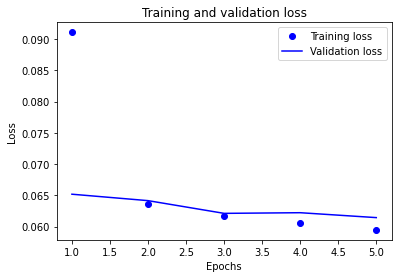

In [ ]:
epochs = range(1, len(acc) + 1)

# "bo" is for "blue dot"
plt.plot(epochs, loss, 'bo', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

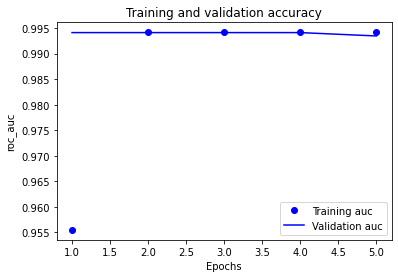

In [ ]:
plt.plot(epochs, acc, 'bo', label='Training auc')
plt.plot(epochs, val_acc, 'b', label='Validation auc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('roc_auc')
plt.legend()

plt.show()